In [1]:
import os
from glob import glob
from pathlib import Path

import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from utils.plotting import plot_trajectory
from utils.processing import (
    normalize_angles_2pi,
    open_file,
    cut_jumps
    )


import seaborn as sns
from scipy import stats
#from scipy.ndimage import gaussian_filter1d
# from utils.processing import (
#     normalize_angles_2pi,
#     open_file,
#     cut_jumps,
#     save_preprocessed_data,
#     open_preprocessed_data,
#     )

#####  parameters to change

In [2]:
#parameter to change! time lag between neighboring points. 0.3 or 0.1? 
NEW_DT = 0.3
# parameter to change! how much of the length of the square field side we consider as the area close to the wall 
wall_perc=0.1
# parameter to change! If angle is in 90+-angInterval (as well as 270+-angInterval) we consider it as an angle 
#approximately parallel to the front wall
angInterval = 10
#parameter to change! number of bins for building averaged angle distributions
bins = 60




In [3]:
DATA_DIR = 'dataset'
PREPROC_DATA_DIR = 'downsamp_preprocessed_dataset'

# 1. open files
dataset_names = sorted(glob(os.path.join(DATA_DIR, '*.txt')))
datasets = {}
for nam in dataset_names:
    k = Path(nam).stem
    v = open_file(nam, show=False)
    datasets[k] = v

# 2. cut_jumps
tr11 = datasets['Trace_1.1']  # TODO: params to config
tr12 = datasets['Trace_1.2']  
tr2 = datasets['Trace_2']
tr5 = datasets['Trace_5']

tr4 = cut_jumps(datasets['Trace_4'], xmax=40.4, xmin=-38.1, ymax=28.3, ymin=-47.6,show=False)
tr3 = cut_jumps(datasets['Trace_3'], xmax=46.8, xmin=-48, ymax=46, ymin=-47,show=False)
tr6 = cut_jumps(datasets['Trace_6'], xmax=45, xmin=-45, ymax=45, ymin=-42.2,show=False)
tr7 = cut_jumps(datasets['Trace_7'], xmax=35, xmin=-38.7, ymax=40, ymin=-32,show=False)
tr91 = cut_jumps(datasets['Trace_9.1'], xmax=42.5, xmin=-43.7, ymax=42.5, ymin=-42.7,show=False)
tr92 = cut_jumps(datasets['Trace_9.2'], xmax=36.3, xmin=-46.5, ymax=45.4, ymin=-47.3,show=False)

dfs = [tr11, tr12, tr2, tr3, tr4, tr5, tr6, tr7, tr91, tr92]
dfs_names = ['tr11', 'tr12', 'tr2','tr3','tr4','tr5','tr6','tr7', 'tr91','tr92']

dfs_dict = {}
for k, val in zip(dfs_names, dfs):
    dfs_dict[k] = val

# 3. rescale x and y coords to fit area size 
# может добавить функцию rescale_coord в processing.py? TODO
def rescale_coord(data, new_min, new_max):
    min_old_x, max_old_x = np.min(data), np.max(data)
    data_rescaled = ((data - min_old_x) / (max_old_x - min_old_x)) * (new_max - new_min) + new_min
    return data_rescaled

AREA_SIZE = [-40, 40]
rescaled_dfs_dict = {}
for k, df in dfs_dict.items():
    df = df.dropna()
    rescaled_x = rescale_coord(df['x'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    rescaled_y = rescale_coord(df['y'].to_numpy(), AREA_SIZE[0], AREA_SIZE[1])
    df.loc[:, 'x'] = rescaled_x
    df.loc[:, 'y'] = rescaled_y

    rescaled_dfs_dict[k] = df

# 4. divide trajectories into sub-trajectories to remove inconsistent dt and Nans
def divide_traj_by_nans(df, k, dt_threshold, traj_drop_threshold=5):
    # 1. Drop Nans
    df = df.dropna()
    # 2. Find if any time jumps
    dt_times = df['time'].diff().to_numpy()
    dt_times[0] = 0.
    div_idx = np.where(dt_times > dt_threshold)[0]
    div_idx = np.asarray(div_idx)

    # Divide by time jumps
    if len(div_idx) > 0:
        div_idx = np.concatenate([np.array([0]),
                                  div_idx,
                                  np.array([len(df)])])
        sub_trajectories = []
        start_i = div_idx[0]
        for end_i in div_idx[1:]:
            if end_i - start_i > traj_drop_threshold:
                sub_df = df[start_i:end_i]
                sub_trajectories.append(sub_df)
            start_i = end_i + 1

        return k, sub_trajectories
    else:
        return k, [df]
    
DROP_THRESHOLD = 5
dt_thresholds = {'tr11': 0.035, 'tr12': 0.035, 'tr2': 0.035, 'tr3': 0.135,  # TODO: to configs
                 'tr4': 0.035,  'tr5': 0.035, 'tr6': 0.035, 'tr7': 0.035,
                 'tr91': 0.035, 'tr92': 0.035}

subtraj_dfs_dict = {}
for k, df in rescaled_dfs_dict.items():
    k, df_subtraj= divide_traj_by_nans(df, k, dt_threshold=dt_thresholds[k],
                                       traj_drop_threshold=DROP_THRESHOLD)
    subtraj_dfs_dict[k] = df_subtraj  # list of dfs

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\1857115902.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'x'] = rescaled_x
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\1857115902.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'y'] = rescaled_y
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\1857115902.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

NEW_DT - 1/ new sampling rate 



In [4]:
# 5. resample to required dt


def resample_data_to_larger_timestep(df, original_dt, new_dt):
    from scipy.signal import resample

    num_original_points = df.shape[0]
    duration = num_original_points * original_dt
    num_new_points = int(duration / new_dt)
    
    resampled_dfnp = resample(df.to_numpy()[:, 1:], num_new_points, axis=0)
    new_time = np.linspace(df['time'].iloc[0], df['time'].iloc[-1], num_new_points)
    #added 3 down change
    #print(resampled_dfnp[:, 0])
    #print(resampled_dfnp)
    if len(resampled_dfnp) > 1:
        resampled_df = pd.DataFrame({'time': new_time,
                                     'x': resampled_dfnp[:, 0], 
                                     'y': resampled_dfnp[:, 1]})
    #added 2 down change
    else:
        resampled_df = pd.DataFrame(columns=['time','x','y'])
    return resampled_df

# NOTE: We ignore that there are TWO most frequent dt-s: 0.033 and 0.034
ORIGINAL_DT = {'tr11': 0.034, 'tr12': 0.034, 'tr2': 0.034, 'tr3': 0.134,  # TODO: to configs
               'tr4': 0.034, 'tr5': 0.034, 
               'tr6': 0.034, 'tr7': 0.034, 'tr91': 0.034, 'tr92': 0.034}


resampled_subtraj_dfs_dict = {}
for k, df in subtraj_dfs_dict.items():
    subtraj_list = []
    for sub_traj_df in df:
        resampled_sub_traj_df = resample_data_to_larger_timestep(sub_traj_df,
                                                                    ORIGINAL_DT[k],
                                                                    NEW_DT)
        #changed
        if len(resampled_sub_traj_df) > 1:
            subtraj_list.append(resampled_sub_traj_df)
    resampled_subtraj_dfs_dict[k] = subtraj_list


# 6. add angles, delta_angles, step len, 
def add_angles(df):
    dt = df['time'].diff()
    vvx = df['x'].diff() / dt 
    vvy = df['y'].diff() / dt 
    dt[0], vvx[0], vvy[0] = 0., 0., 0.

    Xx = np.arctan2(vvx, vvy)
    Nres = normalize_angles_2pi(Xx)
    ang = np.rad2deg(Nres) % 360
    df['angles'] = ang
    return df

def add_delta_angles(df):
    dangles = df['angles'].diff()
    dangles[0] = 0.
    dangles_rad = np.deg2rad(dangles)
    normed_dangels_rad = normalize_angles_2pi(dangles_rad)
    df['delta_angle'] = np.rad2deg(normed_dangels_rad) % 360
    return df

def add_step_length(df):
    dx = df['x'].diff()
    dy = df['y'].diff()
    dx[0], dy[0] = 0., 0.,
    step_lens = (dx**2 + dy**2)**0.5
    df['step_length'] = step_lens
    return df


dfs_dict_with_angles = {}
for k, df in resampled_subtraj_dfs_dict.items():
    subtraj_list = []
    for sub_traj_df in df:
        df_ang = add_angles(sub_traj_df)
        df_dt_ang = add_delta_angles(df_ang)
        df_step = add_step_length(df_dt_ang)
        subtraj_list.append(df_step)
    dfs_dict_with_angles[k] = subtraj_list

# 7. sort by areas of open field
#долго выполняется если рисовать все графики


def sort_walls_area(tr, border_tr, wall_percent=0.1): 
    ylen = border_tr['ymax'] - border_tr['ymin'] 
    xlen = border_tr['xmax'] - border_tr['xmin'] 
    xl = border_tr['xmin'] + xlen * wall_percent
    xr = border_tr['xmax'] - xlen * wall_percent
    yd = border_tr['ymin'] + ylen * wall_percent
    yu = border_tr['ymax'] - ylen * wall_percent

    tr['near_wall'] = 0.
    for i in range(len(tr)):     
        if tr['x'].iloc[i] < xl:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 40
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 30
            else:
                tr['near_wall'].iloc[i] = 4
        elif tr['x'].iloc[i] > xr:
            if tr['y'].iloc[i] > yu:
                tr['near_wall'].iloc[i] = 10
            elif tr['y'].iloc[i] < yd:
                tr['near_wall'].iloc[i] = 20
            else:
                tr['near_wall'].iloc[i] = 2
        elif tr['y'].iloc[i] > yu:
            tr['near_wall'].iloc[i] = 1
        elif tr['y'].iloc[i] < yd:
            tr['near_wall'].iloc[i] = 3
    return tr

def plot_wall_sorted_samples(df, plot_title):
    all_areas = [40, 30, 20, 10, 4, 3, 2, 1, 0]
    for a in all_areas:
        x = df.loc[df['near_wall'] == a]['x']
        y = df.loc[df['near_wall'] == a]['y']
        plt.scatter(x, y, s=1.5, label=str(a))
    plt.gca().set_aspect('equal')
    plt.title(plot_title)
    plt.legend(loc='center')
    plt.show()


dfs_with_walls = {}
bord40 =  {'xmin': -40,'xmax': 40,'ymin': -40,'ymax': 40}   

for k, df in dfs_dict_with_angles.items():
    subtraj_list = []
    for sub_df in df:
        sub_df = sort_walls_area(sub_df, bord40, wall_perc)
        #plot_wall_sorted_samples(sub_df, k)
        subtraj_list.append(sub_df)
    dfs_with_walls[k] = subtraj_list







##### 7.5 highlight pauses. we define pause as situation when sum of mice step len is less than 10? 
#mb these parameters should be changed for other datasets

In [5]:
#7.5 highlight pauses

#реализацию оригинальных семплов с скользящим окном см чуть ниже в черновике. я не поняла как ее сомещать с ресемплом
window_size = 2 #так ближе всего к 0.5 с

def movementOrNot(step_sum):
    if step_sum == -100:
        out = 'NotDefined'
    elif step_sum > max_step_of_stop:
        out = 'Move'
    elif step_sum <= max_step_of_stop:
        out = 'Stop'
    else:
        out = 'error'
    return out

#добавляем dx
#PARAMETER TO CHANGE !!!
max_step_of_stop = 1

#если в цикле менять что-то в ldf, то изменения вносятся и в оригинальный словарь subtraj_dfs_dict или нет???
dfs_stop = {}
for k, df in dfs_with_walls.items():
    sub_list = []
    for ldf in df:
        ldf = ldf.iloc[1:]
        if len(ldf) >= window_size:
            # Extract 'Close' column and convert to DataFrame
            ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
            ldf['step_sum_0.5']=ldf['step_sum_0.5'].fillna(-100)
            func = np.vectorize(movementOrNot)
            ldf["movement"] = func(ldf['step_sum_0.5'])
            sub_list.append(ldf)
    dfs_stop[k] = sub_list





C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5']=ldf['step_sum_0.5'].fillna(-100)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5']=ldf['step_sum_0.5'].fillna(-100)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf["movement"] = func(ldf['step_sum_0.5'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf["movement"] = func(ldf['step_sum_0.5'])
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_22404\830212909.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [6]:
# 8. merge dfs of each mouse
#dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
#the first row from each df is deleted because it has angle 0 and delta angle 0
#ну он хоть как-то соотвествует видео)))
merg_resampled_dfs_dict = {}
mv = []
mv_wall = []
mv_cent = []
mv_corn = []
st = []
for k, df in dfs_stop.items():
    df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_resampled_dfs_dict[k] = pd.concat(df)
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
for k,df in merg_resampled_dfs_dict.items():
    print(k,'perc of move', len(df.loc[df['movement']=='Move'])/len(df))
    mv.append(len(df.loc[df['movement']=='Move'])/len(df))
    
    wall_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=1)&(df['near_wall']<=4)])\
    /len(df.loc[(df['near_wall']>=1)&(df['near_wall']<=4)])
    corn_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']>=10)&(df['near_wall']<=40)])\
    /len(df.loc[(df['near_wall']>=10)&(df['near_wall']<=40)])
    cent_m = len(df.loc[(df['movement']=='Move')&(df['near_wall']==0)])\
    /len(df.loc[(df['near_wall']==0)])
    mv_wall.append(wall_m)
    mv_cent.append(cent_m)
    mv_corn.append(corn_m)
    
    mv.append(len(df.loc[df['movement']=='Move'])/len(df))
    print(k,'perc of stop', len(df.loc[df['movement']=='Stop'])/len(df))
    st.append(len(df.loc[df['movement']=='Stop'])/len(df))
print('move, mean',np.mean(mv))
print('stop, mean',np.mean(st))
print('mv_wall',mv_wall)
print('move near wall, mean',np.mean(mv_wall))
print('move near center, mean',np.mean(mv_cent))
print('move near corner, mean',np.mean(mv_corn))

for k in merg_resampled_dfs_dict:
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].loc[merg_resampled_dfs_dict[k]['movement']=='Move']

    
    

tr11 perc of move 0.543408900083963
tr11 perc of stop 0.45659109991603697
tr12 perc of move 0.48998485103517925
tr12 perc of stop 0.5100151489648207
tr2 perc of move 0.35729957805907175
tr2 perc of stop 0.6427004219409282
tr3 perc of move 0.8311242022582229
tr3 perc of stop 0.16887579774177713
tr4 perc of move 0.8552803129074316
tr4 perc of stop 0.14471968709256844
tr5 perc of move 0.8977777777777778
tr5 perc of stop 0.10222222222222223
tr6 perc of move 0.7569650266745702
tr6 perc of stop 0.24303497332542975
tr7 perc of move 0.8006463340739245
tr7 perc of stop 0.19935366592607554
tr91 perc of move 0.6386435888378664
tr91 perc of stop 0.3613564111621335
tr92 perc of move 0.24908200734394126
tr92 perc of stop 0.7509179926560587
move, mean 0.6420212579051949
stop, mean 0.3579787420948051
mv_wall [0.6455223880597015, 0.5749448934606907, 0.4173509460906819, 0.8506600660066007, 0.9628378378378378, 0.9543189368770764, 0.7866200262352426, 0.809631985461154, 0.5729619959384973, 0.12053346753900

## построим распределение углов для зон у стен

[66, 70, 135, 184, 208, 227, 303, 316, 328, 351] [62, 155, 291, 312, 433, 439, 502, 513, 539, 778]
198 385


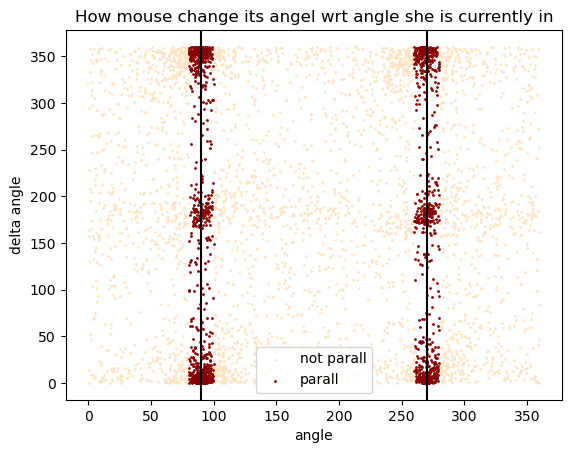

[65, 88, 173, 184, 214, 252, 263, 268, 375, 388] [65, 193, 336, 382, 400, 439, 460, 649, 757, 801]
202 393


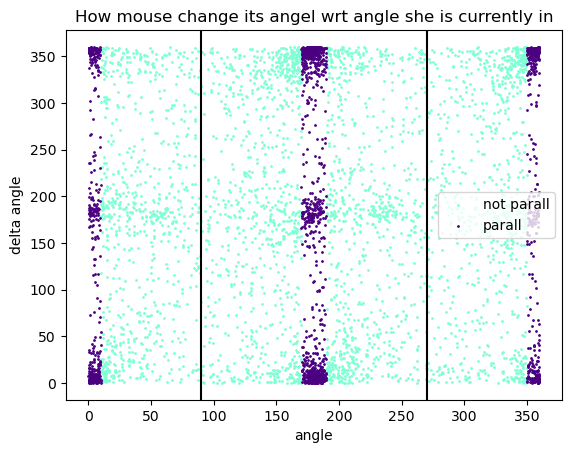

In [7]:
# 9.make 4 general dfs (for all mice) for angles +- parallel to the wall in areas 1 and 3, other angles 
# in areas 1 and 3, +- parallel to the wall in areas 2 and 4, other angles in areas 2 and 4

#make scatter plot of near wall delta angles with respect to angles

#проверено, насколько уменьшилось количество точек по сравнению с вариантом где не вырезаны первые строки суб траектории
#там 5704, тут 5547
DfsStep13, DfsStep24 = {}, {}
n=0
for k, df in merg_resampled_dfs_dict.items():
    DfsStep13[k] = df.loc[(df['near_wall']==1) | (df['near_wall']==3)]
    DfsStep13[k] = DfsStep13[k].reset_index()
    DfsStep13[k] = DfsStep13[k].drop(['index'], axis=1) 
    n += len(DfsStep13[k])

    DfsStep24[k] = df.loc[(df['near_wall']==2) | (df['near_wall']==4)]
    DfsStep24[k] = DfsStep24[k].reset_index()
    DfsStep24[k] = DfsStep24[k].drop(['index'], axis=1)


#we took approximately equal number of points from every mouse for par13 (dfs where mice are 
#in areas 1 + 3 and their vectors are +- parallelto the wall or not parallel (regular angles)  
par13 = []
reg13 = []
p13len = []
r13len = []
for k, df in DfsStep13.items():
    mask = ((df['angles']>=90-angInterval) & (df['angles']<=90+angInterval)) \
                               | ((df['angles']>=270-angInterval) & (df['angles']<=270+angInterval))
    parallel_df = df.loc[mask]
    not_parallel_df = df[~mask]
    p13len.append(len(parallel_df))
    r13len.append(len(not_parallel_df))
    par13.append(parallel_df) 
    reg13.append(not_parallel_df)
print(sorted(p13len), sorted(r13len))
lp13 =round(np.percentile(p13len, 40))
lr13 = round(np.percentile(r13len, 40))
print(lp13,lr13)

for i in range(len(par13)):
    if len(par13[i]) > lp13:
        par13[i] = par13[i].iloc[0:lp13]
for i in range(len(reg13)):
    if len(reg13[i]) > lr13:
        reg13[i] = reg13[i].iloc[0:lr13]


dfPar13 = pd.concat(par13)
dfReg13 = pd.concat(reg13)

plt.scatter(dfReg13['angles'], dfReg13['delta_angle'], s=1, color='bisque', label='not parall')
plt.scatter(dfPar13['angles'], dfPar13['delta_angle'], s=1, color='darkred', label='parall')
plt.axvline(90, c='black')
plt.axvline(270, c='black')
plt.legend()
plt.title('How mouse change its angel wrt angle she is currently in')
plt.xlabel('angle')
plt.ylabel('delta angle')
plt.show()


#in areas 2 + 4  
par24 = []
reg24 = []
p24len = []
r24len = []
for k, df in DfsStep24.items():
    mask = ((df['angles']>=90-angInterval) & (df['angles']<=90+angInterval)) \
                               | ((df['angles']>=270-angInterval) & (df['angles']<=270+angInterval))
    mask = ((df['angles']>=360-angInterval) | (df['angles']<=angInterval)) \
                            | ((df['angles']>=180-angInterval) & (df['angles']<=180+angInterval))
    parallel_df = df.loc[mask]
    not_parallel_df = df[~mask]
    p24len.append(len(parallel_df))
    r24len.append(len(not_parallel_df))
    par24.append(parallel_df) 
    reg24.append(not_parallel_df)
print(sorted(p24len), sorted(r24len))
lp24 =round(np.percentile(p24len, 40))
lr24 = round(np.percentile(r24len, 40))
print(lp24,lr24)

for i in range(len(par24)):
    if len(par24[i]) > lp24:
        par24[i] = par24[i].iloc[0:lp24]
for i in range(len(reg24)):
    if len(reg24[i]) > lr24:
        reg24[i] = reg24[i].iloc[0:lr24]


dfPar24 = pd.concat(par24)
dfReg24 = pd.concat(reg24)

plt.scatter(dfReg24['angles'], dfReg24['delta_angle'], s=1, color='aquamarine', label='not parall')
plt.scatter(dfPar24['angles'], dfPar24['delta_angle'], s=1, color='indigo', label='parall')
plt.axvline(90, c='black')
plt.axvline(270, c='black')
plt.legend()
plt.title('How mouse change its angel wrt angle she is currently in')
plt.xlabel('angle')
plt.ylabel('delta angle')
plt.show()

Bin size is 5.9996142763815365 (degrees)


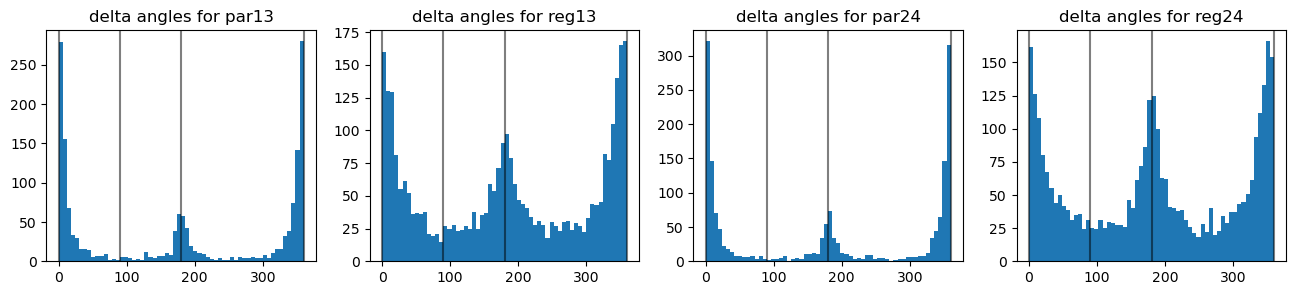

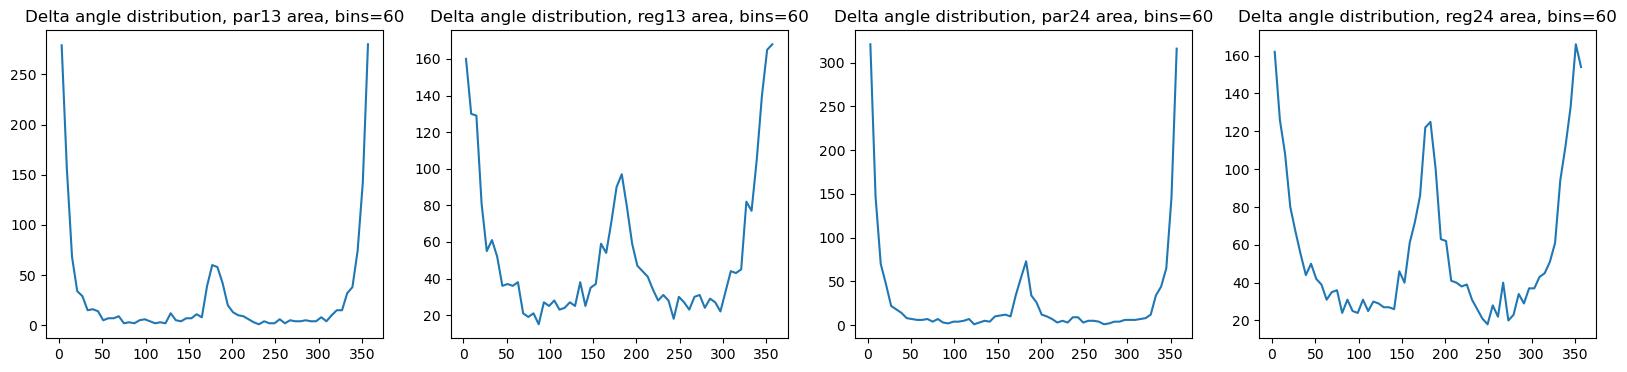

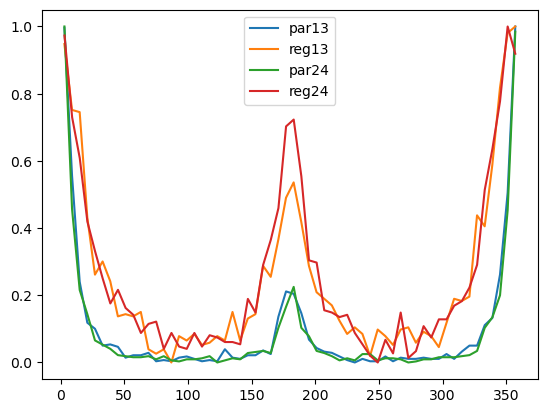

In [8]:
# 10. make hists of near wall delta angle distributions near the wall. we consider 2 types of angles: angles that are
#  +- parallel to the walls and others  
wall_hist = {}
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
names = ['par13', 'reg13', 'par24', 'reg24']
for i, dat in enumerate([dfPar13, dfReg13, dfPar24, dfReg24]):
    freqs, binEdges, _ = axes[i].hist(dat['delta_angle'], bins=bins)
    if i ==0:
        print(f'Bin size is {binEdges[1] - binEdges[0]} (degrees)')
    for ang in [0, 90, 180, 360]:
        axes[i].axvline(ang, c='black', alpha=0.5)
    axes[i].set_title(f'delta angles for {names[i]}')

    bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
    wall_hist[names[i]] = [bin_mid, freqs]
plt.show()

#all together
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
u = 0
for i, h in wall_hist.items():
    #axes[u]  = fig.add_subplot(2, 2, 1)
    axes[u].plot(h[0], h[1])
    axes[u].set_title(f'Delta angle distribution, {i} area, bins={bins}')
    u += 1
plt.show()

#all normalized
def min_max_normalize(y):
    yn = (y - y.min()) / (y.max() - y.min())
    return yn

for k, df in wall_hist.items():
    df[1] = min_max_normalize(df[1])
    plt.plot(df[0], df[1], label=k)
plt.legend()
plt.show()


# all together
# for i, dat in enumerate([dfPar13, dfReg13, dfPar24, dfReg24]):
#     plt.hist(dat['delta_angle'], label=names[i], alpha=0.5, bins=bins)
# for ang in [0, 90, 180, 360]:
#     plt.axvline(ang, c='black', alpha=0.5)
# plt.title('All delta angles together')
# plt.legend()
# plt.show()

#save picture parameter




In [11]:
# # Save distributions
# import pickle
# with open(f'New_Walls_Distr_nbins_{bins}.pkl', 'wb') as fp:
#     pickle.dump(wall_hist, fp)
    

{'nearWalls': 287, '0': 533, 'corner': 96}
For area corner df len=3086
For area wall df len=9347
For area center df len=4688


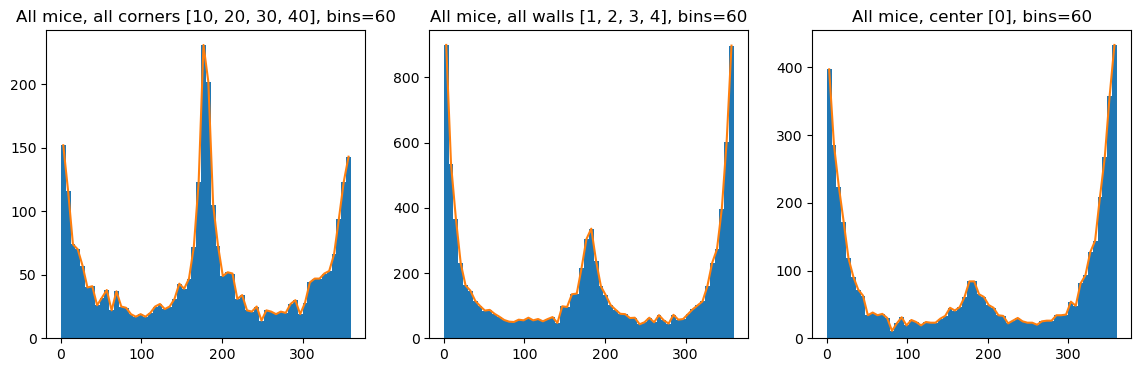

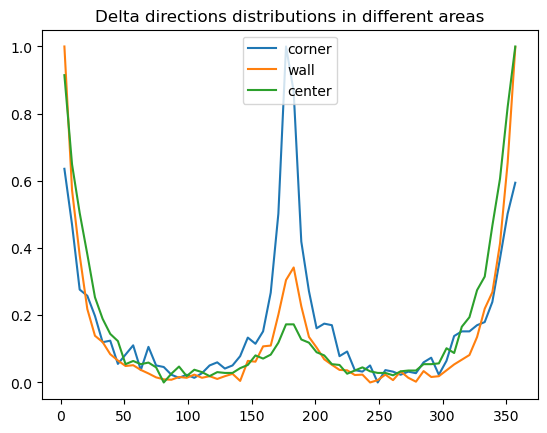

In [16]:
# 10. we took the same amount of point from every mouse from every type of area (center(area 0), near walls, corners)
# to build averaged angle/delta angle distributions

MaxLenDict = {}
all_l = []
for area in [1, 2, 3, 4]:
    for k, df in merg_resampled_dfs_dict.items():    
        all_l.append(len(df.loc[df["near_wall"] == area]))
MaxLenDict['nearWalls'] = round(np.percentile(all_l, 40))

all_l=[]
for k, df in merg_resampled_dfs_dict.items():    
    all_l.append(len(df.loc[df["near_wall"] == 0]))
MaxLenDict['0'] = round(np.percentile(all_l, 40))

all_l=[]
for area in [10, 20, 30, 40]:
    for k, df in merg_resampled_dfs_dict.items():    
        all_l.append(len(df.loc[df["near_wall"] == area]))
MaxLenDict['corner'] = round(np.percentile(all_l, 40))
    
print(MaxLenDict)

def cut_into_dict(dfs_dict, area, max_len):
    cutted_df_dict = {}
    for k, df in dfs_dict.items():
        # print(k + ' ' + str(area))  # tmp
        cutted_df = df.loc[df['near_wall'] == area]
        # print(len(cutted_df))  # tmp
        cutted_df = cutted_df.iloc[:max_len]
        # print(len(cutted_df))  # tmp
        cutted_df_dict[k] = cutted_df

    return cutted_df_dict

walls = [10, 20, 30, 40]
near_corner_dict = {}
for w in walls:
    near_corner_dict[w] = cut_into_dict(merg_resampled_dfs_dict, w, MaxLenDict['corner'])

walls = [1, 2, 3, 4]  # TODO different max_len ???
near_wall_dict = {}
for w in walls:
    near_wall_dict[w] = cut_into_dict(merg_resampled_dfs_dict, w, MaxLenDict['nearWalls'])

walls = [0]
near_center_dict = {}
for w in walls:
    near_center_dict[w] = cut_into_dict(merg_resampled_dfs_dict, w, MaxLenDict['0'])

def merge_df(df_dict):
    delta_ang_list = []
    for k, dfdfdf in df_dict.items():
        for l, df in dfdfdf.items():
            #delta_ang_list.append(df['delta_angle'])
            delta_ang_list.append(df)
        dfN = pd.concat(delta_ang_list)
        dfN = dfN.reset_index()
        dfN = dfN.drop(['index'], axis=1)
    return dfN

#хз плохо ли что для распределений в разные типы зон берется разное количество точек. можно взять одинаковое
#понятно что из полученных словарей (near_wall_dict и тд) легко построить распределение для каждой зоны

#made df for every zone (corners, center, walls)
aver_delta_angles = {}

aver_corner = merge_df(near_corner_dict)
print(f'For area corner df len={len(aver_corner)}')
aver_delta_angles['corner'] = aver_corner['delta_angle']

aver_wall = merge_df(near_wall_dict)
print(f'For area wall df len={len(aver_wall)}')
aver_delta_angles['wall'] = aver_wall['delta_angle']

aver_center = merge_df(near_center_dict)
print(f'For area center df len={len(aver_center)}')
aver_delta_angles['center'] = aver_center['delta_angle']

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
delta_ang_hist = {}

freqs, binEdges, _ = axes[0].hist(aver_delta_angles['corner'], bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['corner']  = [bin_mid, freqs]
axes[0].plot(bin_mid, freqs)
axes[0].set_title(f'All mice, all corners [10, 20, 30, 40], bins={bins}')

freqs, binEdges, _ = axes[1].hist(aver_delta_angles['wall'], bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['wall']  = [bin_mid, freqs]
axes[1].plot(bin_mid, freqs)
axes[1].set_title(f'All mice, all walls [1, 2, 3, 4], bins={bins}')

freqs, binEdges, _ = axes[2].hist(aver_delta_angles['center'], bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
delta_ang_hist['center']  = [bin_mid, freqs]
axes[2].plot(bin_mid, freqs)
axes[2].set_title(f'All mice, center [0], bins={bins}')

plt.figure()
for k, l in delta_ang_hist.items():
    l[1] = min_max_normalize(l[1])
    plt.plot(l[0], l[1], label=k)
plt.title('Delta directions distributions in different areas')
plt.legend()
plt.show()

# # Save distributions
# import pickle
# with open(f'New_DeltaAng_Distr_nbins_{bins}.pkl', 'wb') as fp:    
#     pickle.dump(delta_ang_hist, fp)
    

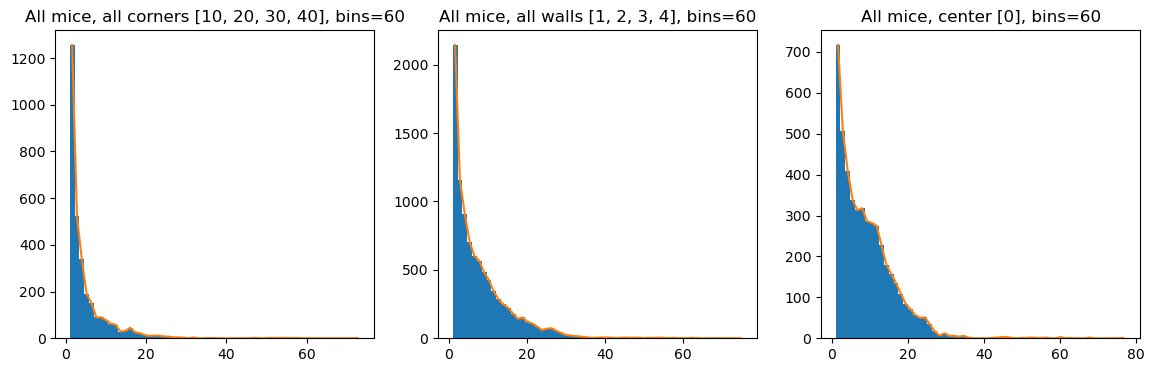

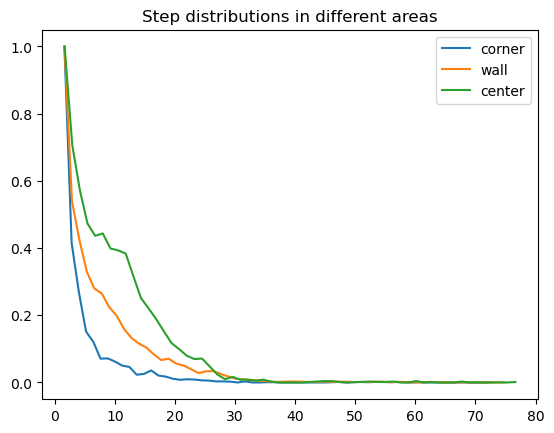

In [21]:
#построим распределения длин шагов для каждой зоны
#made df for every zone (corners, center, walls)
aver_step = {}

aver_step['corner'] = aver_corner['step_sum_0.5']

aver_step['wall'] = aver_wall['step_sum_0.5']

aver_step['center'] = aver_center['step_sum_0.5']

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
step_hist = {}

freqs, binEdges, _ = axes[0].hist(aver_step['corner'], bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
step_hist['corner']  = [bin_mid, freqs]
axes[0].plot(bin_mid, freqs)
axes[0].set_title(f'All mice, all corners [10, 20, 30, 40], bins={bins}')

freqs, binEdges, _ = axes[1].hist(aver_step['wall'], bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
step_hist['wall']  = [bin_mid, freqs]
axes[1].plot(bin_mid, freqs)
axes[1].set_title(f'All mice, all walls [1, 2, 3, 4], bins={bins}')

freqs, binEdges, _ = axes[2].hist(aver_step['center'], bins=bins)
bin_mid = 0.5 * (binEdges[1:] + binEdges[:-1])
step_hist['center']  = [bin_mid, freqs]
axes[2].plot(bin_mid, freqs)
axes[2].set_title(f'All mice, center [0], bins={bins}')

plt.figure()
for k, l in step_hist.items():
    l[1] = min_max_normalize(l[1])
    plt.plot(l[0], l[1], label=k)
plt.title('Step distributions in different areas')
plt.legend()
plt.show()


In [23]:
# # Save distributions
# import pickle
# with open(f'New_Step_Distr_nbins_{bins}.pkl', 'wb') as fp:    
#     pickle.dump(step_hist, fp)
    

### draft

In [27]:
#draft for 7.5 highlight pauses. we define pause as situation when sum of mice step len is less than 10?
# #parameter for dx (0.5 s: sum of dx in 0.034 s). we suggest that velocity more than 20/s is not a pause. sounds strange
# #d пока взят наобум
# #import math
# d = 10
# window_size = round(0.5/0.034)
# window_size


# #remove TODO
# subtraj_dfs_dict1 = {}
# subtraj_dfs_dict1['tr6'] = subtraj_dfs_dict['tr6']
# subtraj_dfs_dict11 = subtraj_dfs_dict1.copy()
# subtraj_dfs_dict11


# #draft
# #i first wanted to apply movementOrNot to original subtraj dfs, but then i noted
# #that when i resample it would be hard to define which rows are pauses 

# def movementOrNot(step_sum):
#     if step_sum == -100:
#         out = 'NotDefined'
#     elif step_sum > max_step_of_stop:
#         out = 'Move'
#     elif step_sum <= max_step_of_stop:
#         out = 'Stop'
#     else:
#         out = 'error'
#     return out

# #добавляем dx
# #PARAMETER TO CHANGE !!!
# max_step_of_stop = 3

# #если в цикле менять что-то в ldf, то изменения вносятся и в оригинальный словарь subtraj_dfs_dict
# len_all = {}
# len_stops = {}
# for k, df in subtraj_dfs_dict1.items():
#     la = 0
#     ls = 0
#     for ldf in df:
#         ldf = add_step_length(ldf)
#         ldf = ldf.iloc[1:]
#         if len(ldf) >= window_size:
#             # Extract 'Close' column and convert to DataFrame
#             ldf['step_sum_0.5'] = ldf['step_length'].rolling(window_size).sum()
#             ldf['step_sum_0.5']=ldf['step_sum_0.5'].fillna(-100)
#             func = np.vectorize(movementOrNot)
#             ldf["movement"] = func(ldf['step_sum_0.5'], )
#             #vectorize is more efficient than apply
            
#             #ldf['movement'] = np.where(int(df['step_length']) > max_step_of_stop, True, False)
            
#             #print(ldf.isna().sum())
#             #plt.plot(ldf['step_sum_0.5'])
            
#             #если разница 0.5 или больше смотрим чтобы сумма дх была не больше 3
#             #все эти точки исключаем как паузу
#             #или все таки сделать паузу после выделения шагов но зачем вроде хуже







In [98]:
#норм ли будет усреднять углы с разным количествои точек?
MaxLenDict = {}
all_l = []
for area in [1, 2, 3, 4]:
    for k, df in merg_resampled_dfs_dict.items():    
        all_l.append(len(df.loc[df["near_wall"] == area]))
MaxLenDict['nearWalls'] = round(np.percentile(all_l, 40))

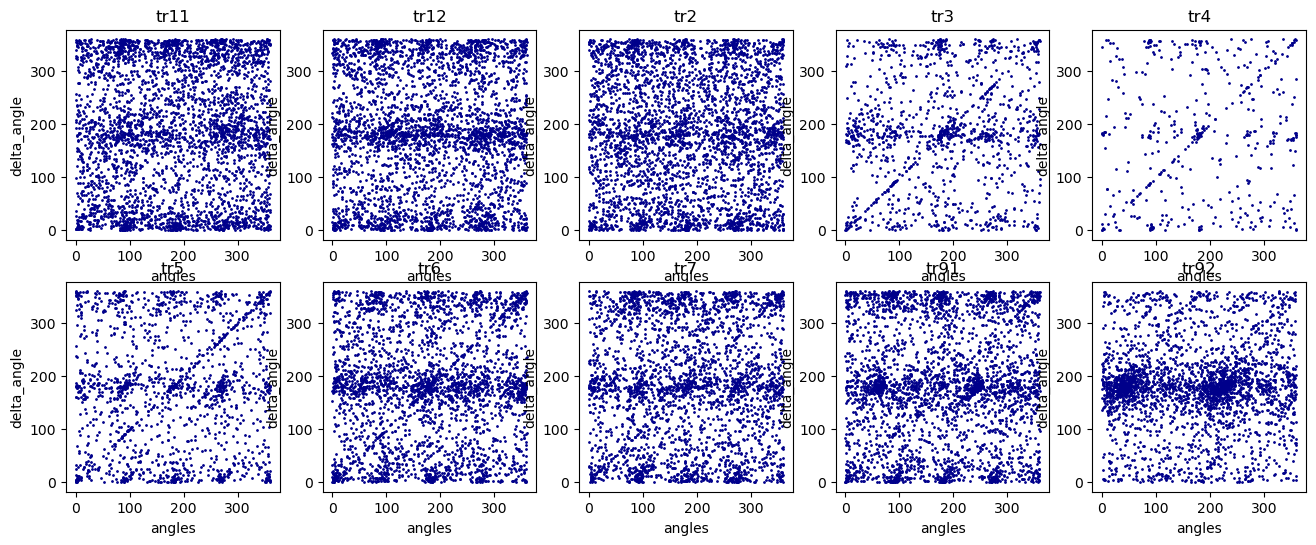

In [10]:
# In 9 all areas
fig, axes = plt.subplots(2, 5, figsize=(16, 6))
j, i = 0, 0
for k in merg_resampled_dfs_dict:
    merg_resampled_dfs_dict[k].plot.scatter(x='angles',y='delta_angle', c='DarkBlue',s=1, ax=axes[j, i])
    axes[j, i].set_title(k)
    i += 1
    if i == 5:
        j = 1
        i = 0
plt.show()

In [15]:

#delete TODO (compare these results with old DeltaDirectionsDistributions01)
# m = 0
# for k, df in resampled_subtraj_dfs_dict.items():
#     n = 0
#     for sub_traj_df in df:
#         n += len(sub_traj_df)
#     m += n
#     print(k,n)
# print('all together', m)
# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# m = 0
# for k, df in resampled_subtraj_dfs_dict.items():
#     n = 0
#     for sub_traj_df in df:
#         n += len(sub_traj_df)
#     m += n
#     print(k,n)
# print('all together', m)

# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# #dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
# merg_resampled_dfs_dict = {}
# for k, df in resampled_subtraj_dfs_dict.items():
#     merg_resampled_dfs_dict[k] = pd.concat(df)
#     merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
# print(merg_resampled_dfs_dict)
# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# #dict, where subtrajectories of 1 mice are merged in 1 df (with time jumps)
# merg_resampled_dfs_dict = {}
# for k, df in resampled_subtraj_dfs_dict.items():
#     merg_resampled_dfs_dict[k] = pd.concat(df)
#     merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
# print(merg_resampled_dfs_dict)

#delete TODO (compare these results with old DeltaDirectionsDistributions01)
# for k, df in merg_resampled_dfs_dict.items():
#     plot_wall_sorted_samples(df,k)
# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# for k, df in merg_resampled_dfs_dict.items():
#     plot_wall_sorted_samples(df,k)
#delete TODO (compare these results with old DeltaDirectionsDistributions01)
# for k, df in merg_resampled_dfs_dict.items():
#     print(k, 'all', len(df))
#     print(k,'1+3', len(df.loc[(df['near_wall']==1) | (df['near_wall']==3)]))
#     print(k,'ratio', (len(df.loc[(df['near_wall']==1) | (df['near_wall']==3)]) / len(df)))
# #delete TODO (compare these results with old DeltaDirectionsDistributions01)
# for k, df in merg_resampled_dfs_dict.items():
#     print(k, 'all', len(df))
#     print(k,'1+3', len(df.loc[(df['near_wall']==1) | (df['near_wall']==3)]))
#     print(k,'ratio', (len(df.loc[(df['near_wall']==1) | (df['near_wall']==3)]) / len(df)))
# for k, df in dfs_dict_with_angles.items():
#     subtraj_list = []
#     for sub_df in df:
#         sub_df = sort_walls_area(sub_df, bord40)
#         #plot_wall_sorted_samples(sub_df, k)
#         subtraj_list.append(sub_df)
#     dfs_with_walls[k] = subtraj_list


In [17]:
# #delete TODO
# #show to Katya Compare
# #ок, будем считать что это +- похоже на старые резы
# for k, df in merg_resampled_dfs_dict.items():
#     plt.figure()
#     plt.title(k)
#     plt.plot(df.iloc[:50]['time'],df.iloc[:50]['angles'])



In [16]:
# delete TODO
# make the same 13 and 24 from merged df
# altDfsStep13, altDfsStep24 = {}, {}
# for i, df in merg_resampled_dfs_dict.items():
#     altDfsStep13[i] = df.loc[(df['near_wall']==1) | (df['near_wall']==3)]
#     altDfsStep13[i] = altDfsStep13[i].reset_index()
#     altDfsStep13[i] = altDfsStep13[i].drop(['index'], axis=1)
#     altDfsStep24[i] = df.loc[(df['near_wall']==2) | (df['near_wall']==4)]
#     altDfsStep24[i] = altDfsStep24[i].reset_index()
#     altDfsStep24[i] = altDfsStep24[i].drop(['index'], axis=1)

# delete TODO
# for k, df in altDfsStep13.items():
#     print(k, len(df))

In [18]:
# delete TODO
# for k, df in altDfsStep13.items():
#     print(k, len(df))

In [ ]:
#merge delete
merg_resampled_dfs_dict = {}
for k, df in dfs_with_walls.items():
    #df = [df0.iloc[1:].reset_index() for df0 in df]
    merg_resampled_dfs_dict[k] = pd.concat(df)
    merg_resampled_dfs_dict[k] = merg_resampled_dfs_dict[k].reset_index(drop=True)
for k,df in merg_resampled_dfs_dict.items():
    print(len(df))

In [ ]:
#delete
DfsStep13, DfsStep24 = {}, {}
n = 0
for k, df in old_merg_resampled_dfs_dict.items():
    DfsStep13[k] = df.loc[(df['near_wall']==1) | (df['near_wall']==3)]
    DfsStep13[k] = DfsStep13[k].reset_index()
    DfsStep13[k] = DfsStep13[k].drop(['index'], axis=1) 
    n += len(DfsStep13[k])

    DfsStep24[k] = df.loc[(df['near_wall']==2) | (df['near_wall']==4)]
    DfsStep24[k] = DfsStep24[k].reset_index()
    DfsStep24[k] = DfsStep24[k].drop(['index'], axis=1)

print(n)

In [ ]:
#merge delete
old_merg_resampled_dfs_dict = {}
for k, df in dfs_with_walls.items():
    #df = [df0.iloc[1:].reset_index() for df0 in df]
    old_merg_resampled_dfs_dict[k] = pd.concat(df)
    old_merg_resampled_dfs_dict[k] = old_merg_resampled_dfs_dict[k].reset_index(drop=True)
for k,df in old_merg_resampled_dfs_dict.items():
    print(len(df))

In [ ]:
#old make DfsStep13, DfsStep24 from not merged dfs
DfsStep13, DfsStep24 = {}, {}
for k, df in dfs_with_walls.items():
    list_k_13 = []
    for sub_df in df:
        sub_df = sub_df.loc[(sub_df['near_wall']==1) | (sub_df['near_wall']==3)]
        list_k_13.append(sub_df)
    DfsStep13[k] = pd.concat(list_k_13)
    DfsStep13[k] = DfsStep13[k].reset_index()
    DfsStep13[k] = DfsStep13[k].drop(['index'], axis=1) 

    list_k_24 = []
    for sub_df in df:
        sub_df = sub_df.loc[(sub_df['near_wall']==2) | (sub_df['near_wall']==4)]
        list_k_24.append(sub_df)
    DfsStep24[k] = pd.concat(list_k_24)
    DfsStep24[k] = DfsStep24[k].reset_index()
    DfsStep24[k] = DfsStep24[k].drop(['index'], axis=1)

In [ ]:
# #delete TODO compare
# #good
# for k, df in DfsStep13.items():
#     print(k, len(df))

In [26]:
q=0
for i, df in near_wall_dict.items():
    for i, ddf in df.items():
        q += len(ddf)
print(q)
    

6894
